In [1]:
import poloniex
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
from collections import defaultdict
import functools
import sys
%matplotlib inline

In [2]:
def coroutine(function):
    @functools.wraps(function)
    def wrapper(*args,**kwargs):
        generator = function(*args, **kwargs)
        next(generator)
        return generator
    return wrapper

In [3]:
def plot(data, lines):
    fig = plt.figure(figsize=(8,3))
    ax = fig.add_subplot(1,1,1)
    ax.plot(data.df.ix[:,0],data.df.ix[:,1], color="b")
    for line in lines:
        l = line["l"]
        xp = line["xp"]
        plt.plot(xp,l(xp),"r",label="trend")
#                 ax.plot(self.buys.ix[:,0],self.buys.ix[:,1],"o", color="red",label="buy")
#                 ax.plot(self.sells.ix[:,0],self.sells.ix[:,1],"D",color="green", label="sell")
    plt.grid(True)
    plt.xlim([data.df[0].min(),data.df[0].max()])
    start = mdates.num2date(data.df[0][0]).strftime("%m/%d(%H:00)")
    end   = mdates.num2date(data.df[0][len(data.df) - 1]).strftime("%m/%d(%H:00)")
    title = start + " - " + end
    plt.title(title)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d(%H:00)'))

In [4]:
class Data:
    
    def get(self,period=300, start=1, end=0):
        start_day = (datetime.datetime.today() - datetime.timedelta(days=start))
        end_day   = (datetime.datetime.today() - datetime.timedelta(days=end))
        self.start_unix = time.mktime(start_day.timetuple())
        self.end_unix   = time.mktime(end_day.timetuple())

        polo = poloniex.Poloniex()
        polo.timeout = 2
        chartUSDT_BTC = polo.returnChartData('USDT_BTC', period=period, start=self.start_unix, end=self.end_unix)
        tmpDate = [chartUSDT_BTC[i]['date'] for i in range(len(chartUSDT_BTC))]
        date = [datetime.datetime.fromtimestamp(tmpDate[i]) for i in range(len(tmpDate))]
        date = mdates.date2num(date)
        data = [float(chartUSDT_BTC[i]['open']) for i in range(len(chartUSDT_BTC))]
        self.df = pd.DataFrame([date,data]).T




In [5]:
class Trend:
    
    ACTIVE, BREAKED = "ACTIVE", "BREAKED"
#     UP,     DOWN = "UP",     "DOWN"
    
    def __init__(self):
        self.state      = Trend.BREAKED
#         self.direction    = Trend.UP
        self.__last_high  = sys.maxsize
        self.__last_low   = sys.maxsize
        self.count        = 0
    
    @property
    def last_high(self):
        return self.__last_high
    
    @last_high.setter
    def last_high(self, value):
        if self.__last_high < value:
            self.count += 1
        else:
            self.reset()
        self.__last_high = value
    
    @property
    def last_low(self):
        return self.__last_low
    
    @last_low.setter
    def last_low(self, value):
        if self.__last_low < value:
            self.count += 1
        else:
            self.reset()
        self.__last_low = value
    
    def reset(self):
        self.count = 0
        

In [6]:
class Line:
    
    def __init__(self):
        self.start = self.end = self.line = None
    
    
    def set_start(self, data):
        self.start = data
        
    
    def set_end(self, data):
        self.end = data
        self.__make_line()
    
    def __make_line(self):
        x = [self.start["date"],self.end["date"]]
        y = [self.start["price"],self.end["price"]]
        z = np.polyfit(x,y,1)
        l = np.poly1d(z)
        xp = np.linspace(x[0],x[1])
        pair = {"xp":xp,"l":l}
        self.line = pair
    
    def expand_line(self, end_date):
        xp = np.linspace(self.start["date"],end_date)
        self.line["xp"] = xp
    

In [7]:
class Singular:
    
    INCREASE, DECREASE = "INCREASE", "DECREASE"
    
    def __init__(self):
        self.direction   = Singular.INCREASE
        self.last_price  = 0
        self.__last_data = None
        self.isSingular  = False
    
    @property
    def last_data(self):
        return self.__last_data
    
    @last_data.setter
    def last_data(self, data):
        value = data["price"]
        if self.direction == Singular.INCREASE and self.last_price > value:
            self.direction = Singular.DECREASE
            self.isSingular = True
        elif self.direction == Singular.DECREASE and self.last_price < value:
            self.direction = Singular.INCREASE
            self.isSingular = True
        else:
            self.isSingular = False
        self.__last_data = data
        self.last_price = value
        
        

In [8]:
class Contoller:
    
    def __init__(self):
        self.singular    = Singular()
        self.minor_trend = Trend()
        self.midle_trend = Trend()
        self.minor_lines = []
        self.medle_lines = []
        self.minor_line  = None
        self.midle_line  = None
        self.pipeline = self.breake_check(
                        self.singular_check(
                        self.minor_trend_check()))
        
    @coroutine
    def breake_check(self, successor=None):
        while True:
            data = (yield)
            if self.minor_trend.state == Trend.ACTIVE:
                l = self.minor_line.line["l"]
                xp= self.minor_line.line["xp"]
                if l(data["date"]) > data["price"] :
                    self.minor_line.expand_line(data["date"])
                    self.minor_lines.append(self.minor_line.line)
                    self.minor_trend.state = Trend.BREAKED
            successor.send(data)
    
    @coroutine
    def singular_check(self, successor=None):
        while True:
            data = (yield)
            last_data = self.singular.last_data
            self.singular.last_data = data
            if self.singular.isSingular:
                successor.send(last_data)
    
    @coroutine
    def minor_trend_check(self, successor=None):
        while True:
            data = (yield)
            if self.minor_trend.state == Trend.BREAKED:
                if self.singular.direction == Singular.DECREASE:
                    self.minor_trend.last_high = data["price"]
                elif self.singular.direction == Singular.INCREASE:
                    self.minor_trend.last_low = data["price"]
                    count = self.minor_trend.count
                    if self.minor_trend.count == 1 or self.minor_trend.count == 2:
                        self.minor_line = Line()
                        self.minor_line.set_start(data)
                    elif self.minor_trend.count == 5 or self.minor_trend.count == 6:
                        self.minor_line.set_end(data)
                        self.minor_trend.state = Trend.ACTIVE
                        self.minor_trend.reset()
            
            
            

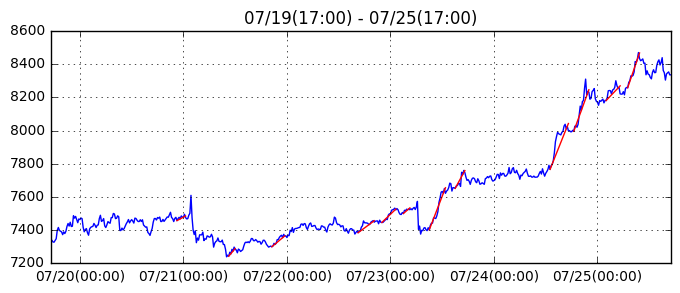

In [9]:
controller = Contoller()
data = Data()
data.get(900,7,1)
for d in data.df.iterrows():
    row = {"date":d[1][0],"price":d[1][1]}
    controller.pipeline.send(row)
lines = controller.minor_lines
plot(data,lines)